In [39]:
import pandas as pd
from decouple import config
import glob
import os
import re
from nilearn.decoding import FREMRegressor
from sklearn.svm import SVR 
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [28]:
task_path = config('eft')
ados = pd.read_csv('/data/project/BEACON/freesurfer/results/behavioural_results.csv')[['G-Number', 'ADOS_Communication',
       'ADOS_Interaction', 'ADOS_com_soc', 'ADOS_Creativity',
       'ADOS_sterotyped_and_repetititve']].dropna()
ados_an = ados[ados['G-Number'].str.contains('G2')].reset_index(drop=True)
paths = glob.glob(os.path.join(task_path, '1stlevel', 'T1', 'sub-G2*', 'ess_0004.nii'))
beta_images_paths = pd.DataFrame(data={
    'id': [re.findall('G2...', participant)[0] for participant in paths],
    'eft_paths': paths,
    'happy_paths': [re.sub('eft', 'happy', path) for path in paths],
    'fear_paths': [re.sub('eft', 'fear', path) for path in paths]
              }).sort_values(by='id')

particpants_with_ados = ados_an[ados_an['G-Number'].isin(beta_images_paths['id'])].reset_index(drop=True)
ados_df = pd.merge(left=particpants_with_ados, 
                   right=beta_images_paths, 
                   left_on='G-Number', 
                   right_on='id').drop('id', axis=1).sort_values(by='G-Number')
ados_df_long = pd.melt(ados_df, 
                       value_vars=['eft_paths', 'happy_paths', 'fear_paths'], 
                       id_vars='G-Number').sort_values(by='G-Number').drop('variable', axis=1).reset_index(drop=True)
ados_long = pd.concat((ados_df.loc[ados_df.index.repeat(3)].reset_index(drop=True), 
                       ados_df_long['value']), 
                       axis=1).drop(['eft_paths', 'happy_paths', 'fear_paths'], axis=1).rename(columns={'value': 'paths'})

In [40]:
frem_dictionary = dict(zip([key for key in ados_df.columns[1:6]], 
                              [list() for key in range(len(ados_df.columns[1:6]))]))

for domain in ados_df.columns[1:6]:
    print(f'\nWorking on {domain}')
    frem = FREMRegressor(estimator=SVR(kernel='linear'))
    frem.fit(ados_long['paths'], ados_long[domain])
    frem_dictionary[domain].append(frem)


Working on ADOS_Communication

Working on ADOS_Interaction


KeyboardInterrupt: 

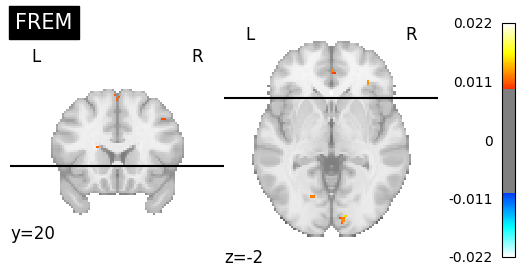

In [34]:
from nilearn.plotting import plot_stat_map

plot_stat_map(
    frem.coef_img_["beta"],
    title="FREM",
    display_mode="yz",
    cut_coords=[20, -2],
    threshold=0.01,
)